In [ ]:
#--------------------------------------------------------------------------#
#                                                                          #
#                     SCRIPT for basic statistic figures                   #
#                                                                          #
#                                                     BY   : KM.Noh        #
#                                                     DATE : 2021.06.09    #
#                                                                          #
#--------------------------------------------------------------------------#

In [6]:
## Modules for Calculate netCDF 
import numpy    as np
import xarray   as xr
import netCDF4 
import pandas as pd

## Modules for caculating statistics
from scipy   import stats, signal
from sklearn import linear_model

## Modules for plottings
import matplotlib.pyplot as plt 
import matplotlib.colorbar as cb
from mpl_toolkits.basemap import Basemap, shiftgrid

plt.rcParams['figure.dpi'] = 300
%config InlineBackend.figue_format = 'retina'

## Modules for modulating systems
import os
import warnings
warnings.filterwarnings('ignore')

## Modules for CSL Basic functions 
from CSL_base import *

## 0. Make Result Directory

In [3]:
#### Make RESULT directory 
dir_name = "./RESULT"

if (os.path.isdir(dir_name)): print("RESULT Directory existed")
else:                         os.mkdir(dir_name)

## 1. Read SST Reanalysis and Station Data

In [4]:
#### Specify the range of lat, lon and time of SST data
latS = -90.      ;   latN = 90.
lonL = 0.        ;   lonR = 360.
yr_str = 1979    ;   yr_end = 2018

In [24]:
#### <Read SST from ERSST 
dir_name   =  "./DATA/"
file_name  =  "sst.ERSST.nc"
path_name  =  dir_name+file_name

## Open the netCDF4 file
var_name   =  "sst"  ;  SST = read_var_latlon_loc(path_name,var_name,yr_str,yr_end,
                                                               latS,latN,lonL,lonR)

#### <Read temp, precip from Station Data
dir_name   =  "./DATA/"
file_name  =  "station.nc"
path_name  =  dir_name+file_name

## Open the netCDF4 file
var_name   =  "temp"  ;  t2m_station = read_var_station_loc(path_name,var_name,yr_str,yr_end)
var_name   =  "prcp"  ;  prcp_station = read_var_station_loc(path_name,var_name,yr_str,yr_end)

In [25]:
#### Read the station detail data
f           = xr.open_dataset(path_name)
station_lon = f.station_lon
station_lat = f.station_lat
station_num = f.station_number

## 2. Make the Nino3.4 Index

In [9]:
#### Specify the Nino3.4 range of lat,lon 
latS_nino = -5.      ;    latN_nino = 5.
lonL_nino = 210.     ;    lonR_nino = 270.

SST_index = extract_index(SST,latS_nino,latN_nino,lonL_nino,lonR_nino)

In [10]:
#### Calculate climatology and anomalies of SST_index
clim_SST_index, anom_SST_index   =  calc_anomaly(SST_index)
clim_SST,       anom_SST         =  calc_anomaly(SST)

anom_SST_ann    = anom_SST.groupby("time.year").mean()
Nt_year, Ny, Nx = anom_SST_ann.shape

In [11]:
#### Remove trend of SST_index & Annual mean 
nino34_SST      =  detrend(anom_SST_index,"time",deg=1)
nion34_SST_ann  =  nino34_SST.groupby("time.year").mean()

season            = ["DJF","MAM","JJA","SON"]

## 3. Time-Series of Nino3.4

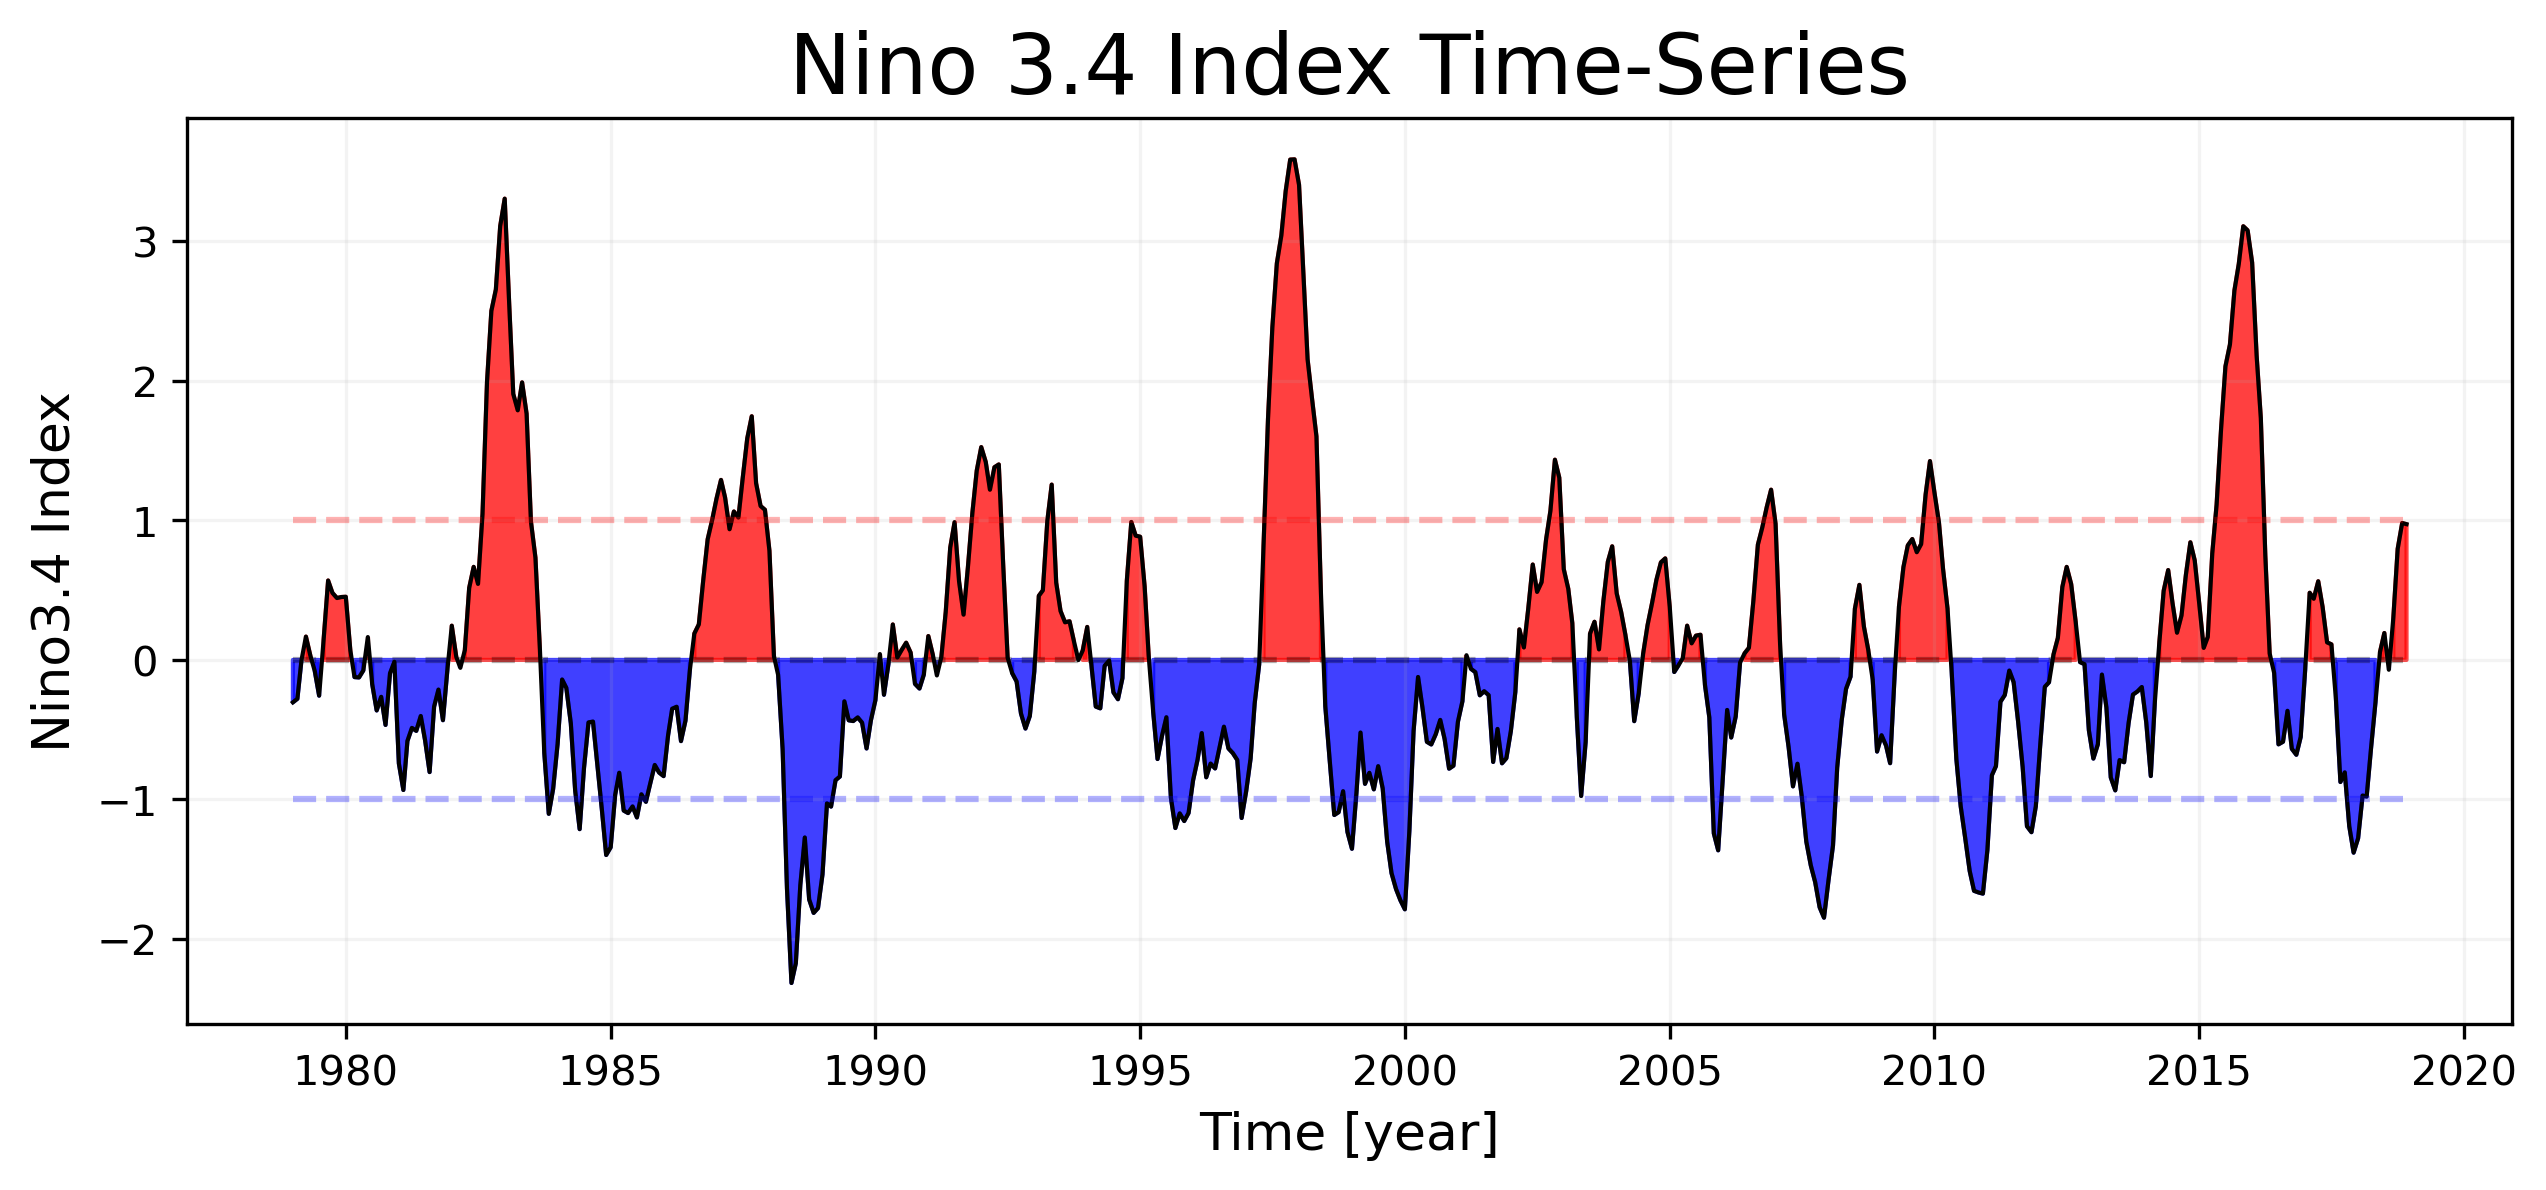

In [12]:
fig, axes = plt.subplots(1,1,figsize=(10,4))
time  = nino34_SST.time.values
index = nino34_SST/nino34_SST.std()


#### Plot Nino3.4 Time Series & Reference line (1 sigma)
axes.plot(time, index ,linewidth=1,color='k',label='Nino3.4')
axes.plot(time, np.zeros(len(time)),  '--',linewidth=1.5,color='k',alpha=0.3)
axes.plot(time, 1*np.ones(len(time)), '--',linewidth=1.5,color='r',alpha=0.3,label='$1\Sigma$')
axes.plot(time, -1*np.ones(len(time)),'--',linewidth=1.5,color='b',alpha=0.3,label='$-1\Sigma$')

#### Fill positive as red and negative as blue
axes.fill_between(time, index, 0, where = (index > 0), color='red', alpha=0.75)
axes.fill_between(time, index, 0, where = (index < 0), color='blue',alpha=0.75)

#### Detail plot properties
axes.set_xlabel("Time [year]",fontsize=12.5)
axes.set_ylabel("Nino3.4 Index",fontsize=12.5)
axes.set_title("Nino 3.4 Index Time-Series",fontsize=20)
axes.grid(alpha=0.15)

#### <Save Time Series Figure to RESULT directory
dir_name   =  "./RESULT/"
file_name  =  "TS_Nino34.pdf"
path_name  =  dir_name+file_name
plt.savefig(path_name)

## 4. SST Regression with Nino3.4

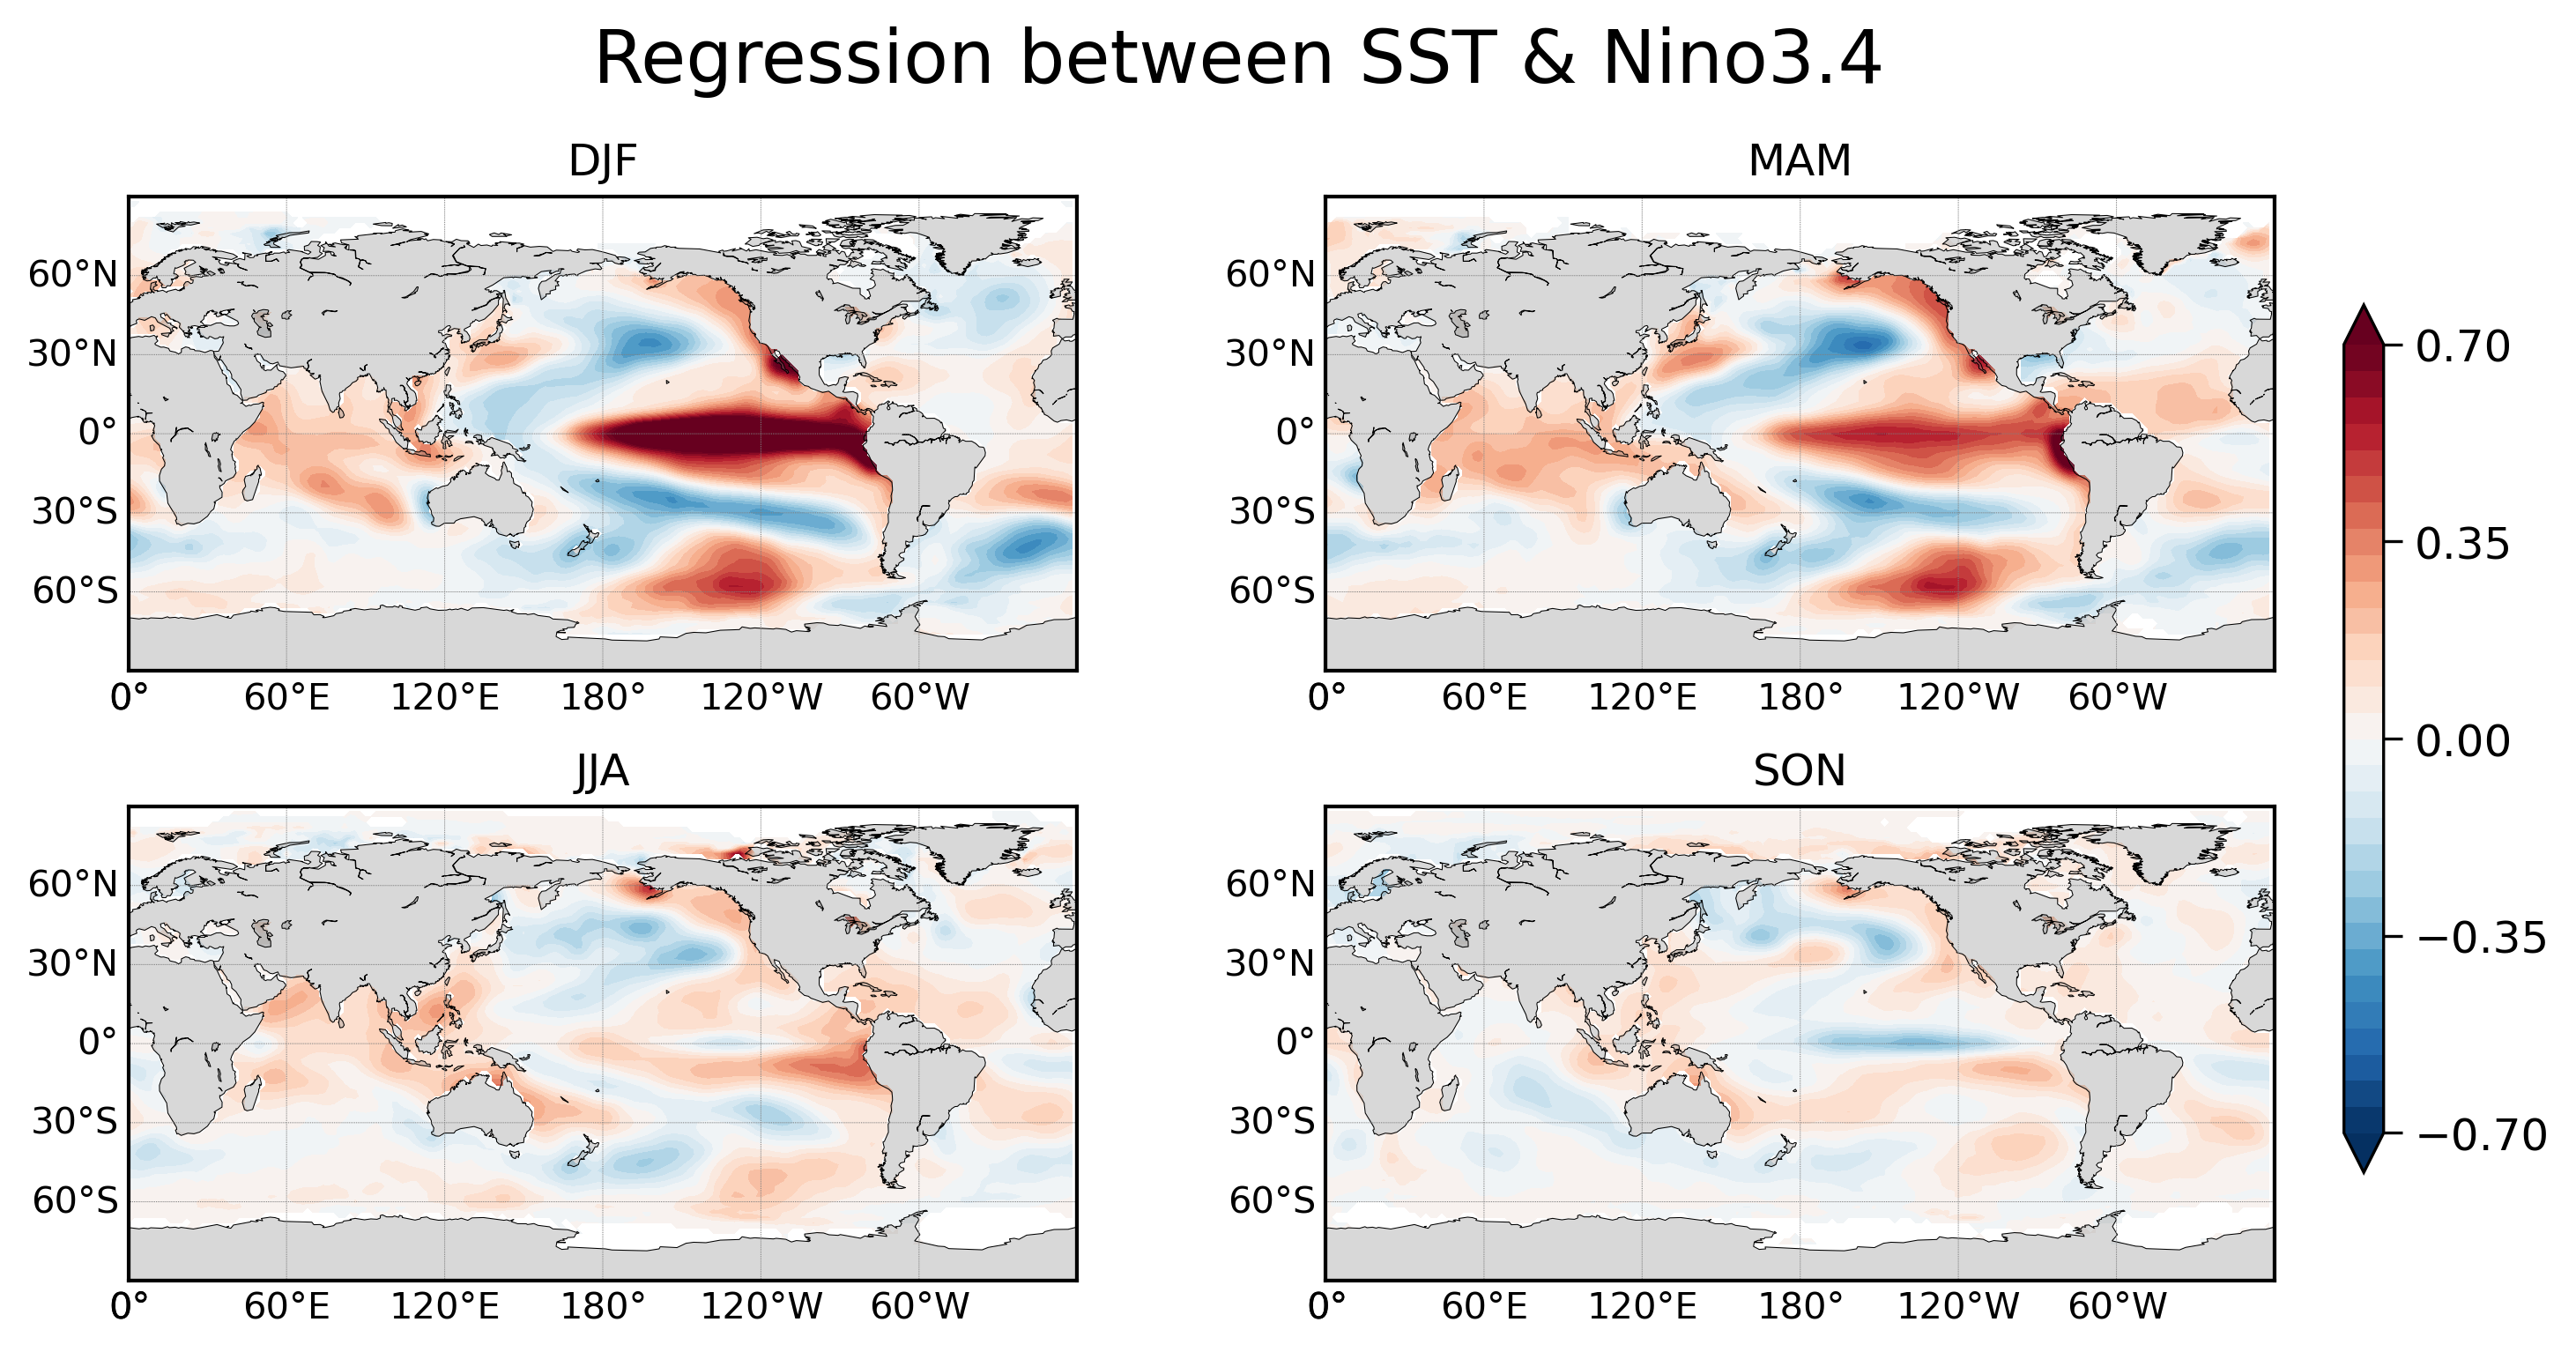

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10,5), constrained_layout = True )
lon0 = -180

for ind_season in range(4):
    ind_x = ind_season//2
    ind_y = ind_season%2

    #### Calclate regression of each season
    if (season[ind_season]=="DJF"):
        var     =  mon_to_ann_season(anom_SST,season[ind_season])[1:Nt_year]
    else:
        var     =  mon_to_ann_season(anom_SST,season[ind_season])[0:Nt_year-1]
        
    ts      =  mon_to_ann_season(nino34_SST,season[0])[1:Nt_year]/mon_to_ann_season(nino34_SST,season[0]).std()
    reg     =  calc_reg(var,ts,"year")

    
    #### Plot regression contour map 
    m, x, y, contour = basemap_cyl(reg, axes[ind_x][ind_y], 
                                   reg.lat.values, reg.lon.values, lon0)

    cmap = plt.get_cmap('RdBu_r')
    vmin = -0.7 ; vmax = 0.7
    nv = 30 ; levels = np.linspace(vmin,vmax,nv+1)
    plot = m.contourf(x, y, contour, 
                      cmap = cmap, levels = levels, extend = 'both')
    axes[ind_x][ind_y].set_title(season[ind_season])
    
    
#### Detail plot properties    
cbar = fig.colorbar(plot, location = 'right', ax = axes, shrink = 0.80, 
                    aspect = 35, pad = 0.02 )
cbar.set_ticks([-0.70,-0.35,0.0,0.35,0.70])
cbar.ax.tick_params( length = 5, labelsize = 12 )

fig.suptitle("Regression between SST & Nino3.4",fontsize=20)

#### <Save Regression Map Figure to RESULT directory
dir_name   =  "./RESULT/"
file_name  =  "Map_Reg_Nino34_SST.pdf"
path_name  =  dir_name+file_name
plt.savefig(path_name)

## 5. SST Correlation with Nino3.4

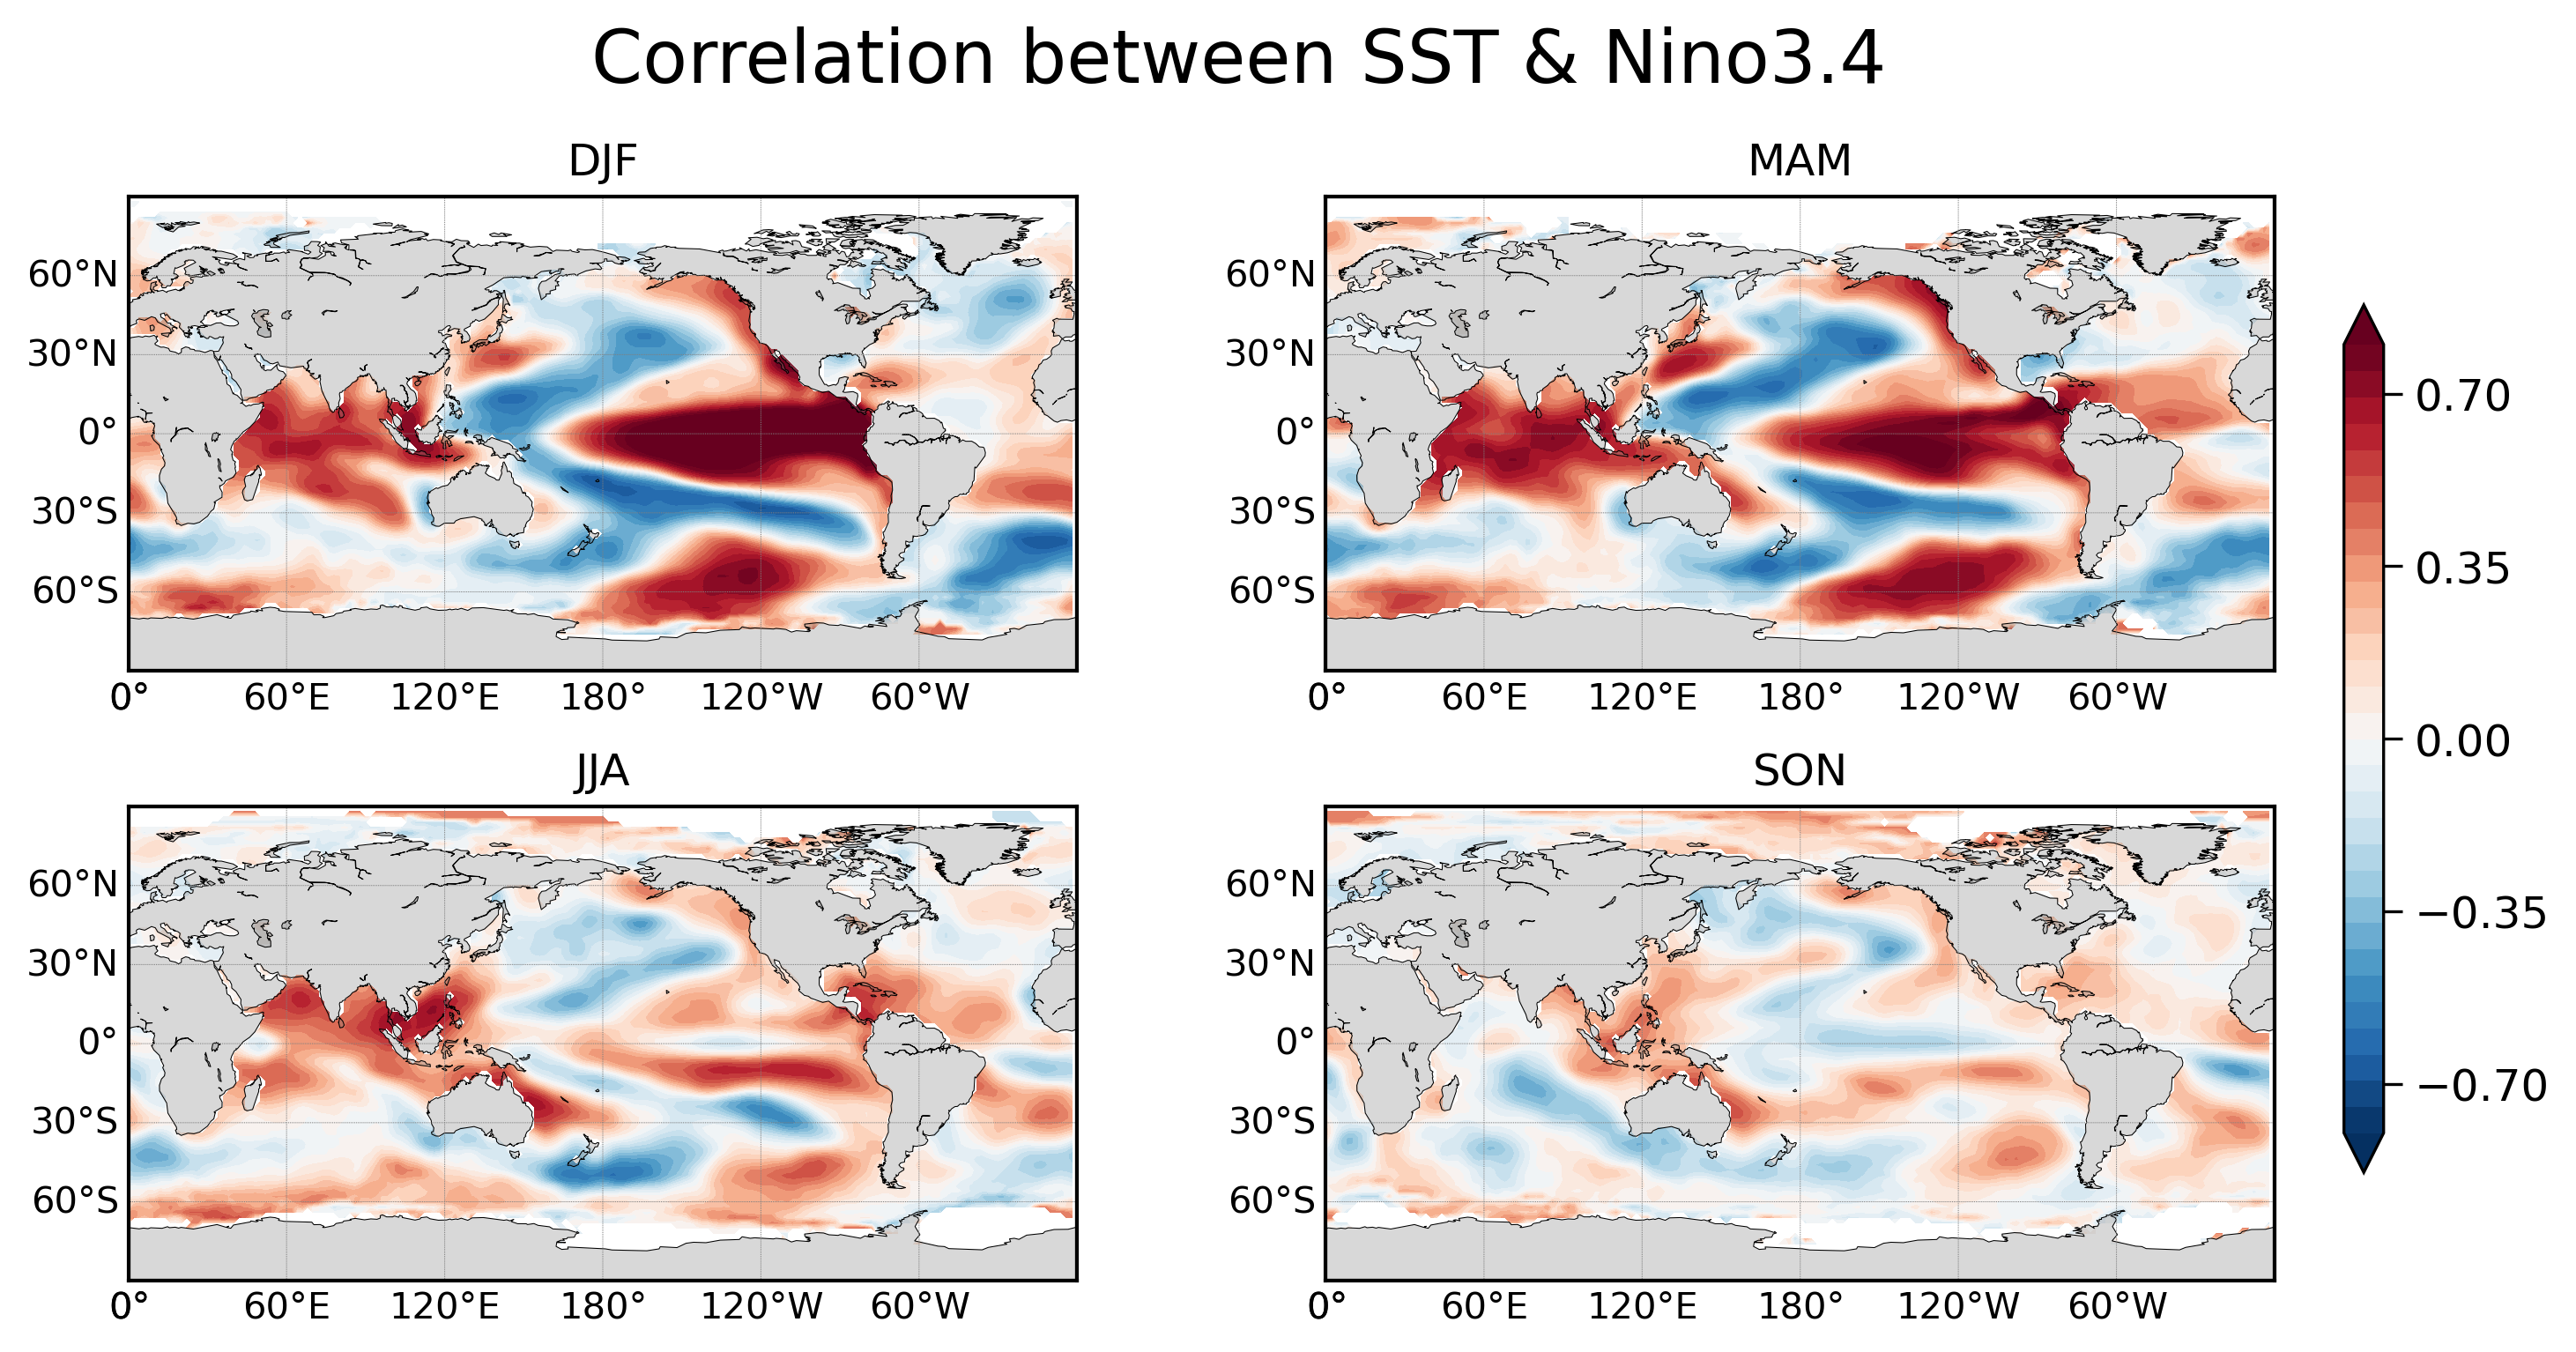

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10,5), constrained_layout = True )
lon0 = -180

for ind_season in range(4):
    ind_x = ind_season//2
    ind_y = ind_season%2
        
    #### Calclate correlation of each season
    if (season[ind_season]=="DJF"):
        var     =  mon_to_ann_season(anom_SST,season[ind_season])[1:Nt_year]
    else:
        var     =  mon_to_ann_season(anom_SST,season[ind_season])[0:Nt_year-1]
        
    ts      =  mon_to_ann_season(nino34_SST,season[0])[1:Nt_year]/mon_to_ann_season(nino34_SST,season[0]).std()
    corr    =  calc_corr(var,ts,"year")
    
    
    #### Plot correlation contour map 
    m, x, y, contour = basemap_cyl(corr, axes[ind_x][ind_y], 
                                   corr.lat.values, corr.lon.values, lon0)

    cmap = plt.get_cmap('RdBu_r')
    vmin = -0.80 ; vmax = 0.80
    nv = 30 ; levels = np.linspace(vmin,vmax,nv+1)
    plot = m.contourf(x, y, contour, 
                      cmap = cmap, levels = levels, extend = 'both')
    axes[ind_x][ind_y].set_title(season[ind_season])
    
    
#### Detail plot properties    
cbar = fig.colorbar(plot, location = 'right', ax = axes, shrink = 0.80, 
                    aspect = 35, pad = 0.02 )
cbar.set_ticks([-0.70,-0.35,0.0,0.35,0.70])
# cbar.set_label(label = '(g/kg)', fontsize = 12)
cbar.ax.tick_params( length = 5, labelsize = 12 )

fig.suptitle("Correlation between SST & Nino3.4",fontsize=20)

#### <Save Correaltion Map Figure to RESULT directory
dir_name   =  "./RESULT/"
file_name  =  "Map_Corr_Nino34_SST.pdf"
path_name  =  dir_name+file_name
plt.savefig(path_name)

## 6. SST Composite with Nino3.4

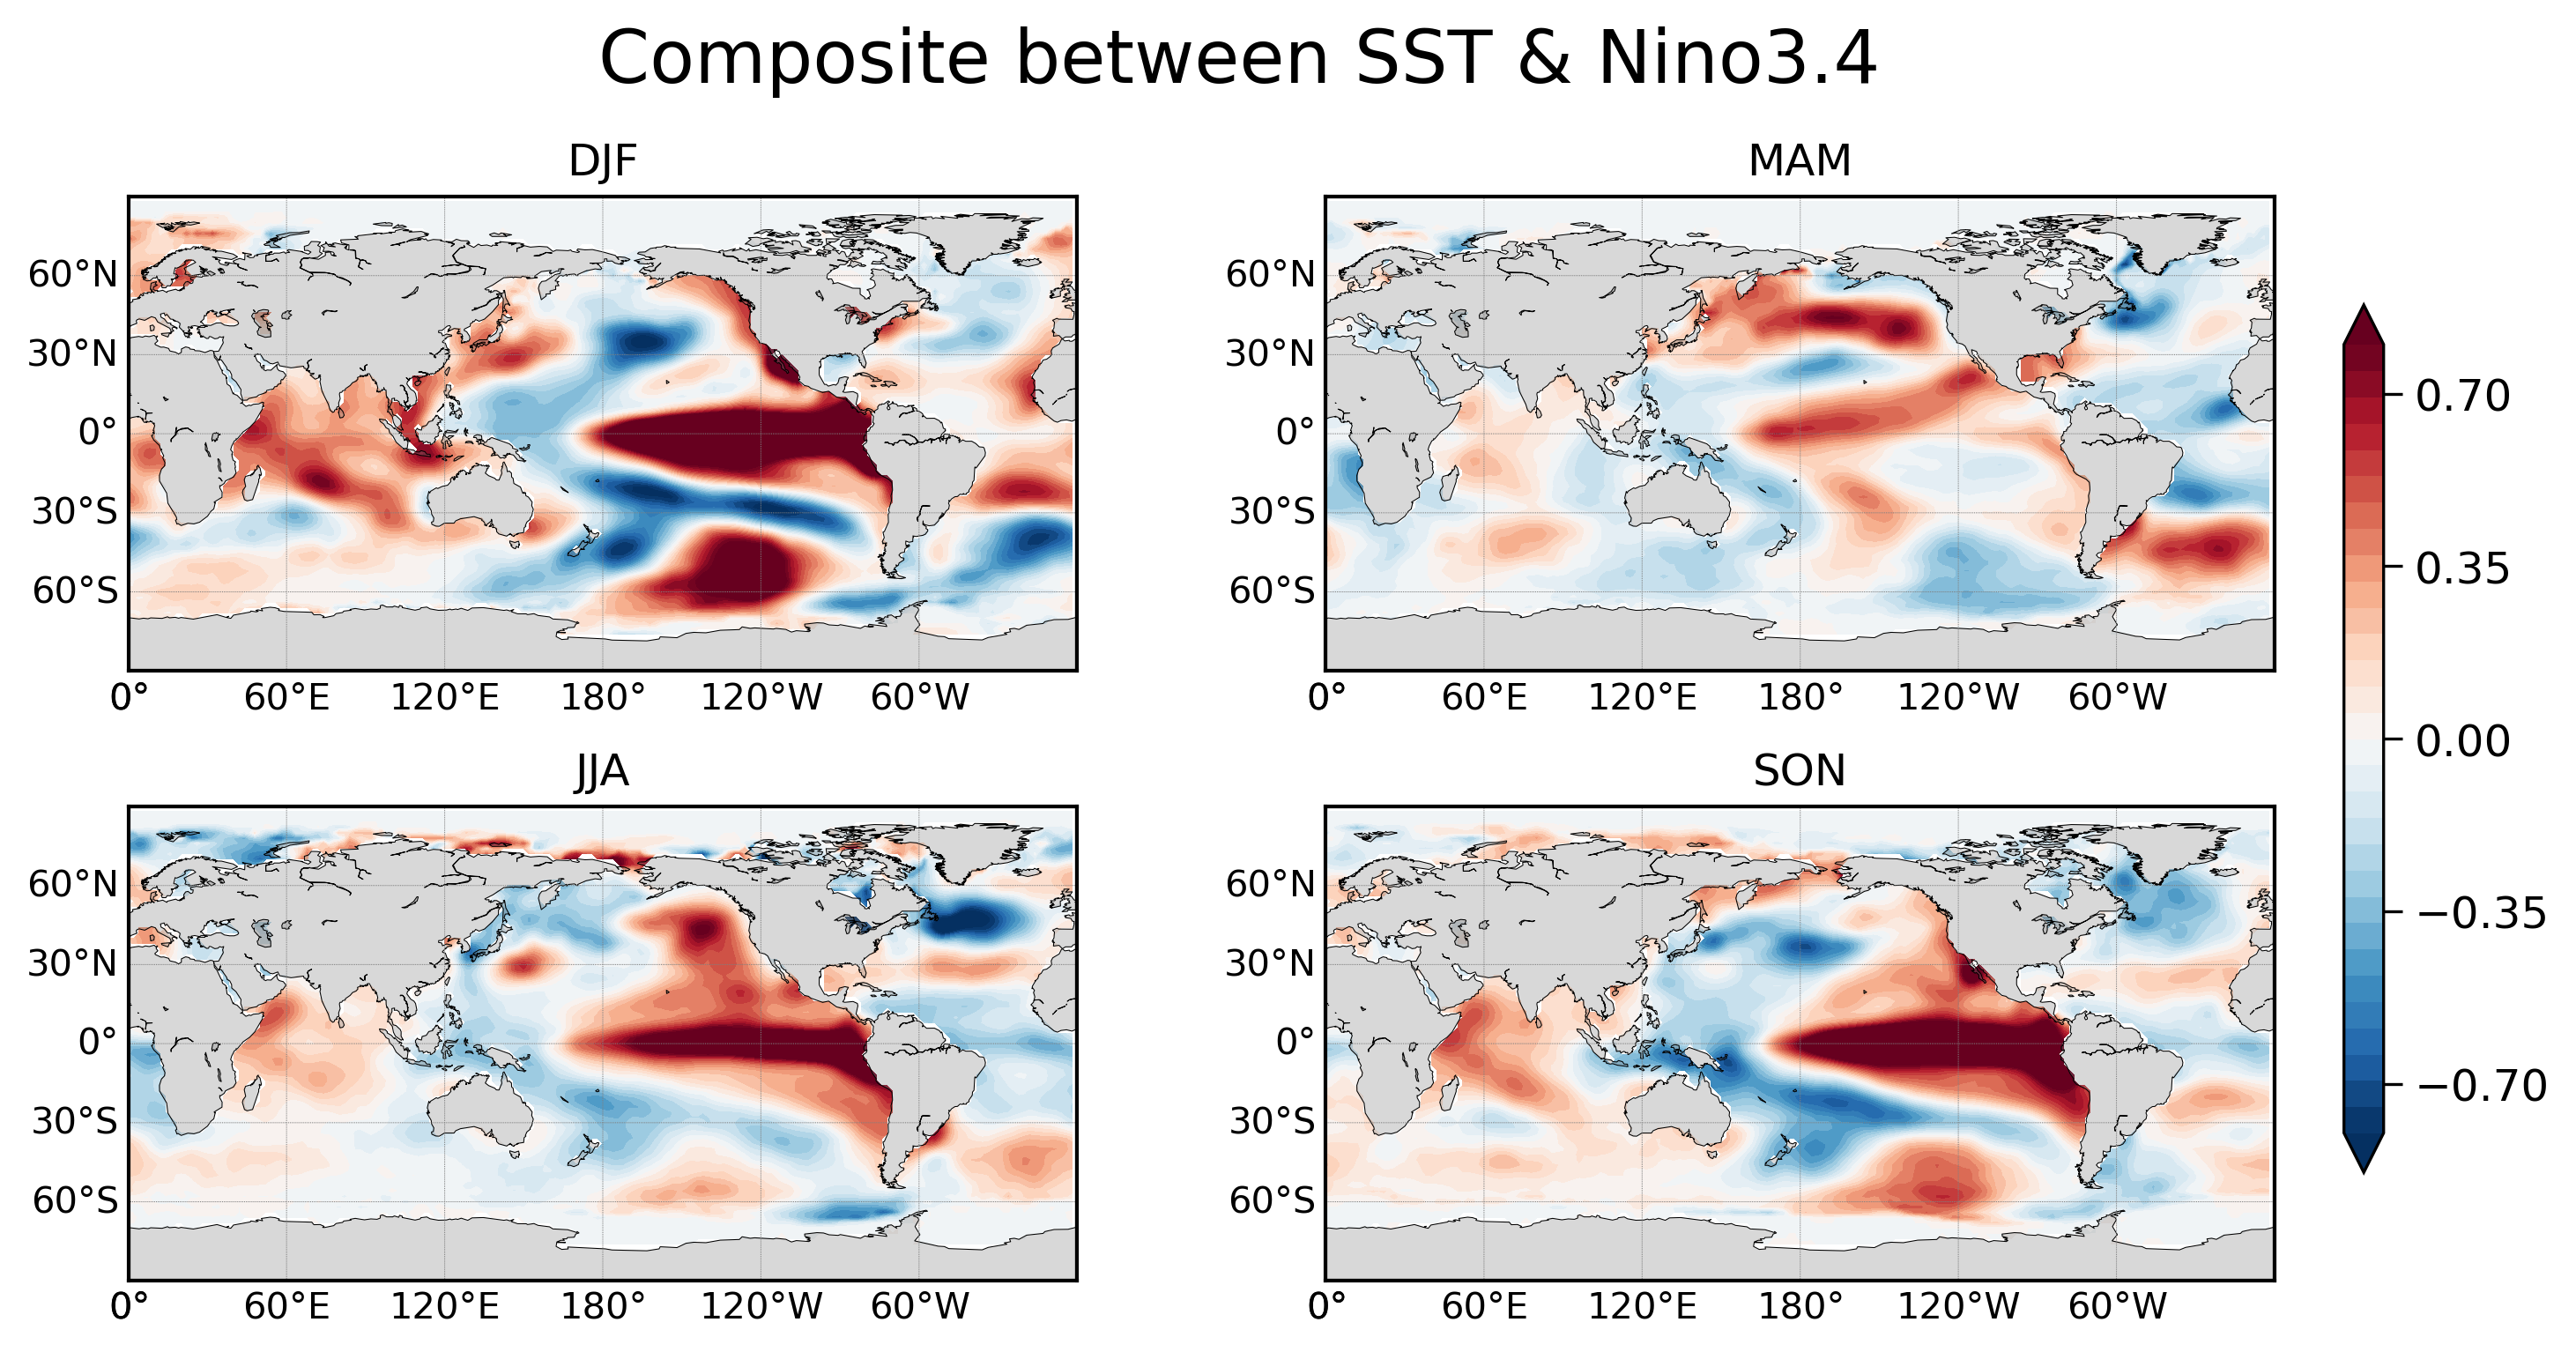

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10,5), constrained_layout = True )
lon0 = -180

for ind_season in range(4):
    ind_x = ind_season//2
    ind_y = ind_season%2
    
    #### Calclate composite of each season        
    if (season[ind_season]=="DJF"):
        var     =  mon_to_ann_season(anom_SST,season[ind_season])[1:Nt_year]
    else:
        var     =  mon_to_ann_season(anom_SST,season[ind_season])[0:Nt_year-1]
        
    ts      =  mon_to_ann_season(nino34_SST,season[0])[1:Nt_year]/mon_to_ann_season(nino34_SST,season[0]).std()
    ind_ts  =  np.where(ts >= 1.0)[0]
    comp    =  calc_comp(var,ts,ind_ts,"year")
    
    
    #### Plot composite contour map 
    m, x, y, contour = basemap_cyl(comp, axes[ind_x][ind_y], 
                                   corr.lat.values, corr.lon.values, lon0)

    cmap = plt.get_cmap('RdBu_r')
    vmin = -0.80 ; vmax = 0.80
    nv = 30 ; levels = np.linspace(vmin,vmax,nv+1)
    plot = m.contourf(x, y, contour, 
                      cmap = cmap, levels = levels, extend = 'both')
    axes[ind_x][ind_y].set_title(season[ind_season])
    
    
#### Detail plot properties    
cbar = fig.colorbar(plot, location = 'right', ax = axes, shrink = 0.80, 
                    aspect = 35, pad = 0.02 )
cbar.set_ticks([-0.70,-0.35,0.0,0.35,0.70])
cbar.ax.tick_params( length = 5, labelsize = 12 )

fig.suptitle("Composite between SST & Nino3.4",fontsize=20)

#### <Save Composite Map Figure to RESULT directory
dir_name   =  "./RESULT/"
file_name  =  "Map_Comp_Nino34_SST.pdf"
path_name  =  dir_name+file_name
plt.savefig(path_name)

## 7. SST & Precipitation Composite in South Korea

In [16]:
#### Calculate climatology and anomalies of each station data
clim_t2m_station,  anom_t2m_station  = calc_anomaly(t2m_station)
clim_prcp_station, anom_prcp_station = calc_anomaly(prcp_station)

#### Detrend anomalies of each station data
anom_detrend_t2m_station  = detrend(anom_t2m_station,dims="time")
anom_detrend_prcp_station = detrend(anom_prcp_station,dims="time")

In [17]:
#### Calclate composite to each station temperature
var     =  mon_to_ann_season(anom_detrend_t2m_station,"DJF")[1:Ny]
ts      =  mon_to_ann_season(nino34_SST,season[0])[1:Ny]/mon_to_ann_season(nino34_SST,season[0]).std()
ind_ts  =  np.where(ts >= 1.0)[0]

comp_t2m_station = calc_comp(var,ts,ind_ts,"year")


#### Calclate composite to each station precipitation
var     =  mon_to_ann_season(anom_detrend_prcp_station,"DJF")[1:Ny]
ts      =  mon_to_ann_season(nino34_SST,season[0])[1:Ny]/mon_to_ann_season(nino34_SST,season[0]).std()
ind_ts  =  np.where(ts >= 1.0)[0]

comp_prcp_station = calc_comp(var,ts,ind_ts,"year")

In [18]:
#### Specifiy the lat-lon range of South-Korea
latS_korea = 32.     ; latN_korea = 41.
lonL_korea = 124.    ; lonR_korea = 131.

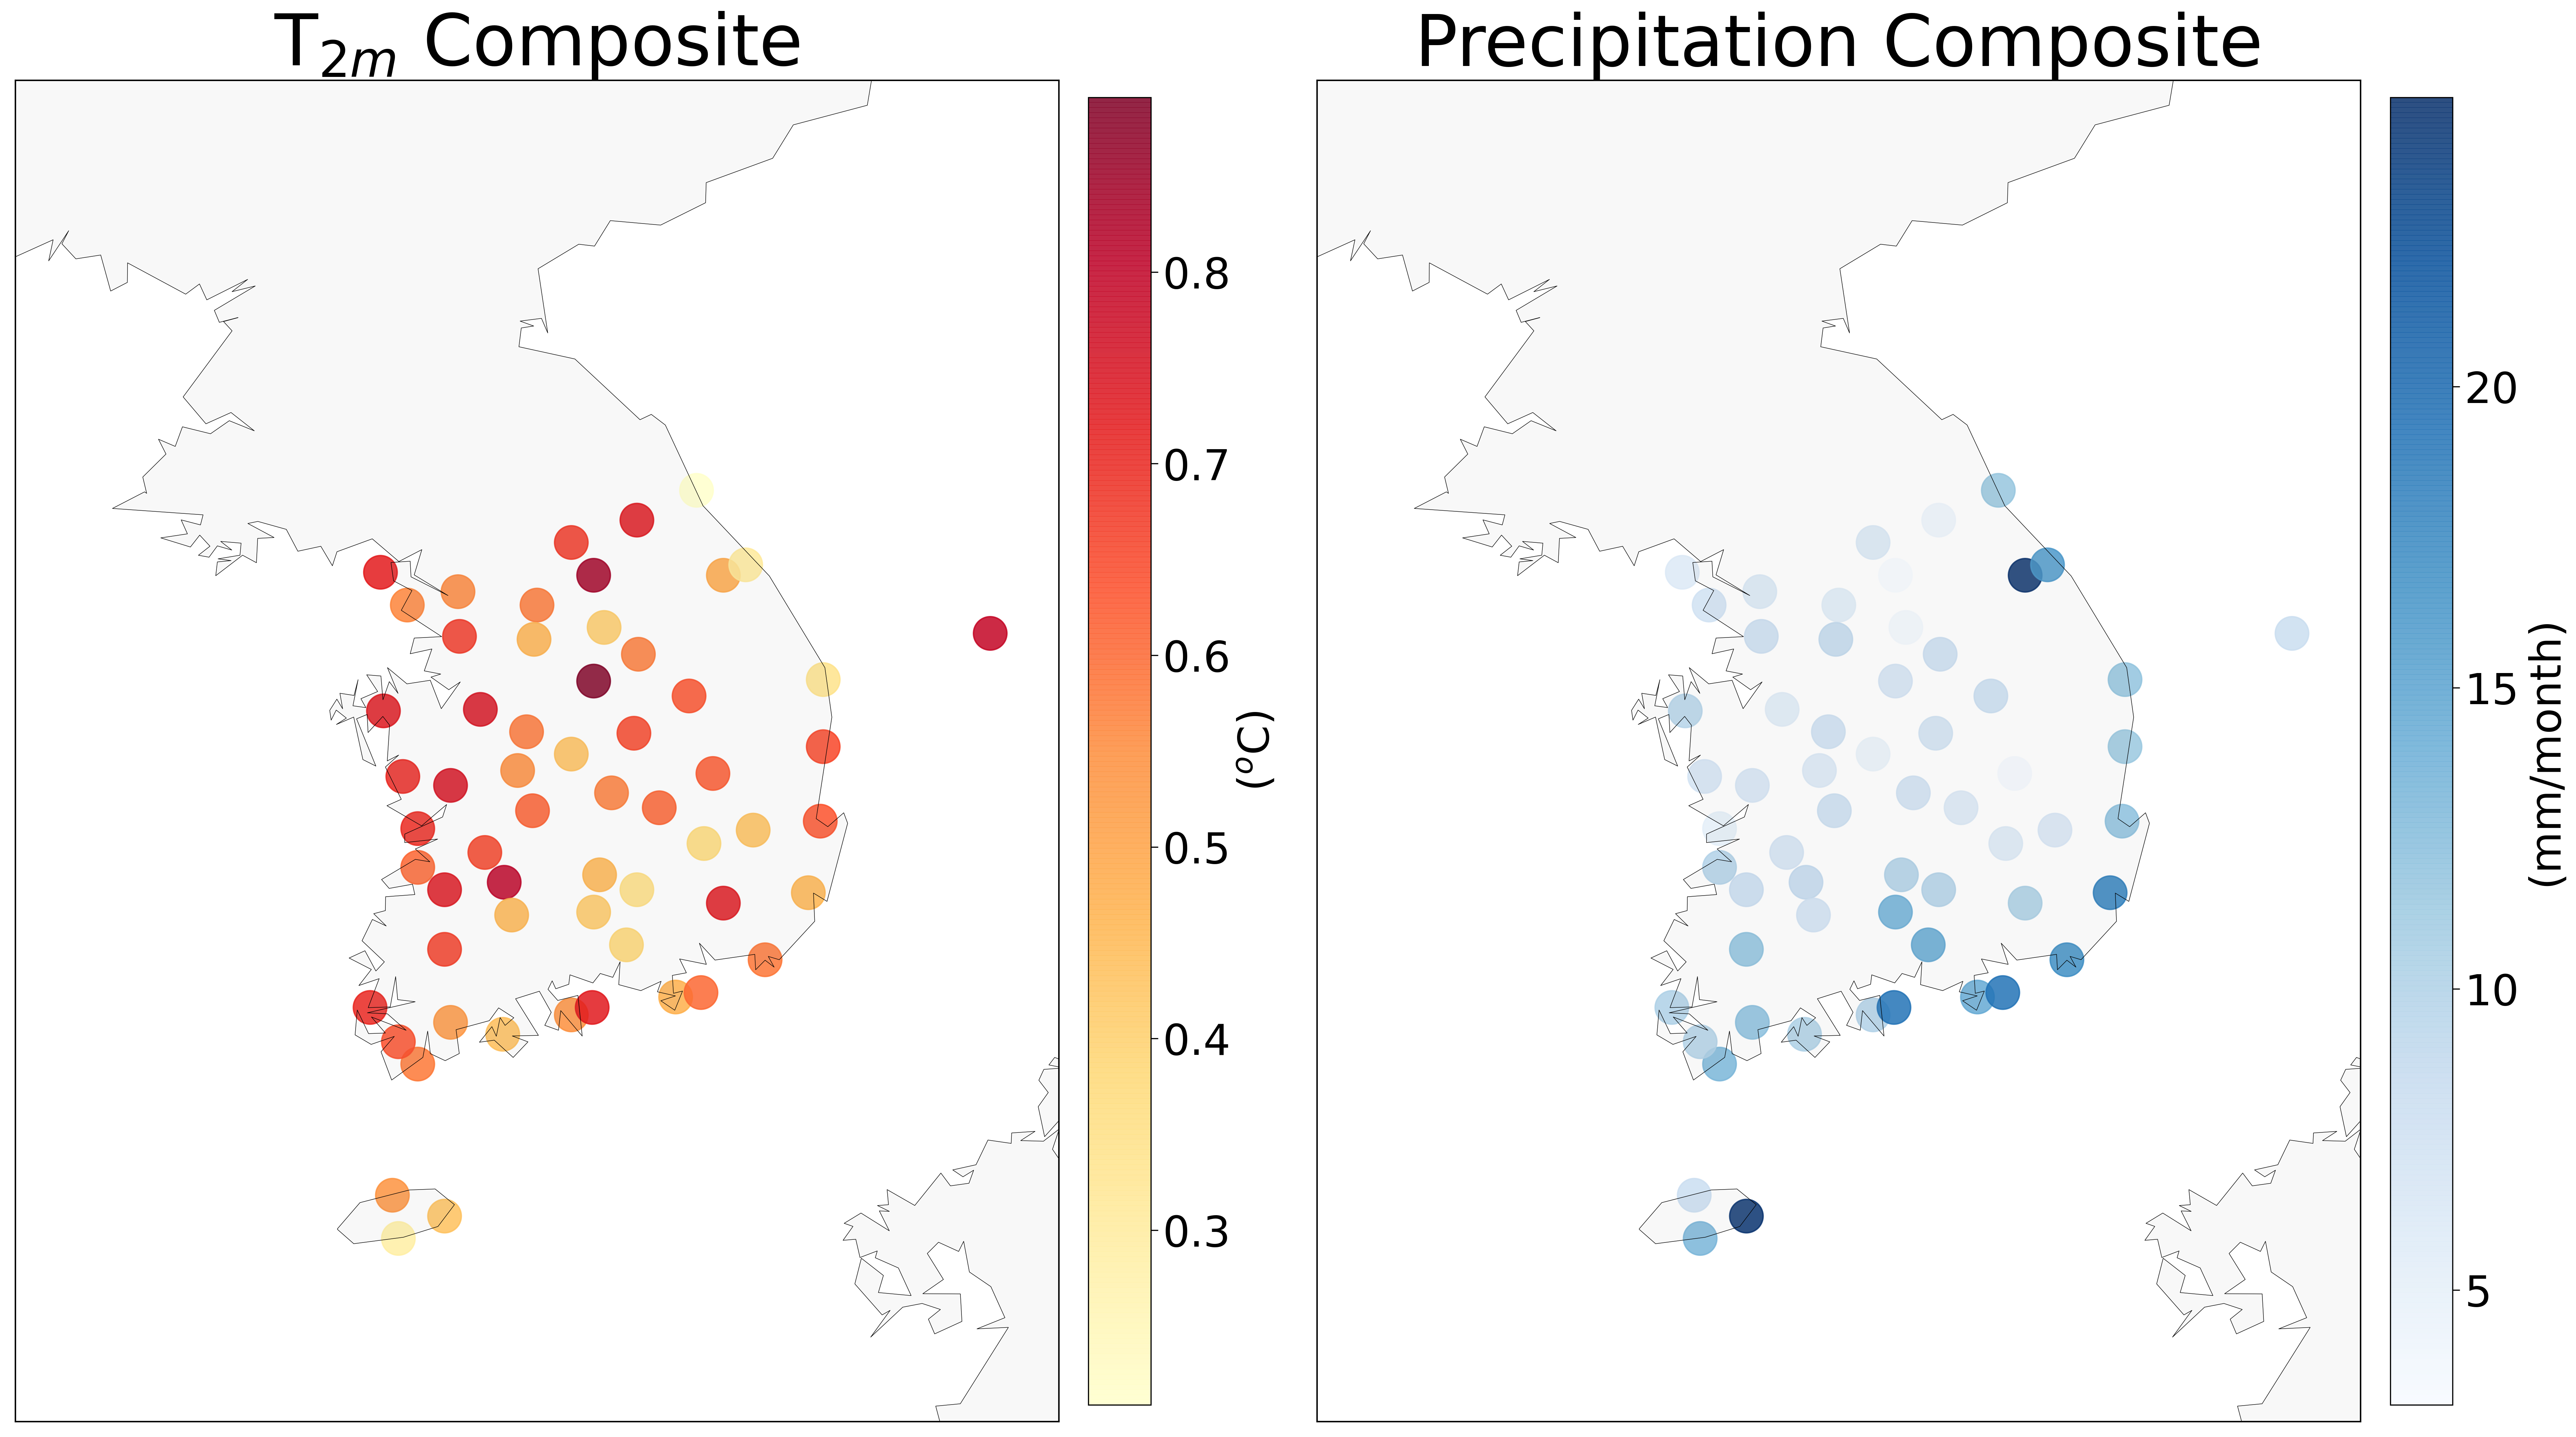

In [19]:
fig, axes = plt.subplots(1,2,figsize=(25,15),constrained_layout=True)

#### Plot Temperature Composite Scatters in South-Korea Station 
m ,x ,y    = basemap_korea(station_lon, station_lat, axes[0], 
                         latS_korea, latN_korea, lonL_korea, lonR_korea)

scat1 = m.scatter(x,y,s=550,c=comp_t2m_station,cmap='YlOrRd',alpha=0.85)

#### Plot Precipitation Composite Scatters in South-Korea Station 
m ,x ,y    = basemap_korea(station_lon, station_lat, axes[1], 
                         latS_korea, latN_korea, lonL_korea, lonR_korea)

scat2 = m.scatter(x,y,s=550,c=comp_prcp_station,cmap='Blues',alpha=0.85)



#### Detail plot properties
axes[0].set_title("T$_{2m}$ Composite",fontsize=50)
axes[1].set_title("Precipitation Composite",fontsize=50)

cbar1 = fig.colorbar(scat1, location = 'right', ax = axes[0], 
                    shrink = 0.85, aspect = 35, pad = 0.02 )
cbar1.set_ticks([-0.1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
cbar1.ax.tick_params( length = 5, labelsize = 30 )
cbar1.set_label(label = '($^o$C)', fontsize = 30)

cbar2 = fig.colorbar(scat2, location = 'right', ax = axes[1], 
                    shrink = 0.85, aspect = 35, pad = 0.02 )
cbar2.set_ticks([-15,-10,-5,0.0,5,10,15,20,25])
cbar2.ax.tick_params( length = 5, labelsize = 30 )
cbar2.set_label(label = '(mm/month)', fontsize = 30)

#### <Save Scatter Map Figure to RESULT directory
dir_name   =  "./RESULT/"
file_name  =  "Map_Scat_Nino34_t2m_prcp_Korea.pdf"
path_name  =  dir_name+file_name
plt.savefig(path_name)

### 8. Scatter Plot (Korea Mean SST & Precip, Nino3.4)

In [20]:
#### Calculate temperature climatology and anomalies of mean station data
t2m_station_mean = t2m_station.mean("station_num")
clim_mean_t2m_station, anom_mean_t2m_station = \
                                           calc_anomaly(t2m_station_mean)
anom_mean_detrend_t2m_station  = detrend(anom_mean_t2m_station,
                                                             dims="time")

#### Calculate precipitation climatology and anomalies of mean station data
prcp_station_mean = prcp_station.mean("station_num")
clim_mean_prcp_station, anom_mean_prcp_station = \
                                          calc_anomaly(prcp_station_mean)
anom_mean_detrend_prcp_station  = detrend(anom_mean_prcp_station,
                                                             dims="time")

In [21]:
var1  =  mon_to_ann_season(nino34_SST,"DJF")[1:Nt_year]
var2  =  mon_to_ann_season(anom_mean_detrend_t2m_station,"DJF")[1:Nt_year]
var3  =  mon_to_ann_season(anom_mean_detrend_prcp_station,"DJF")[1:Nt_year]

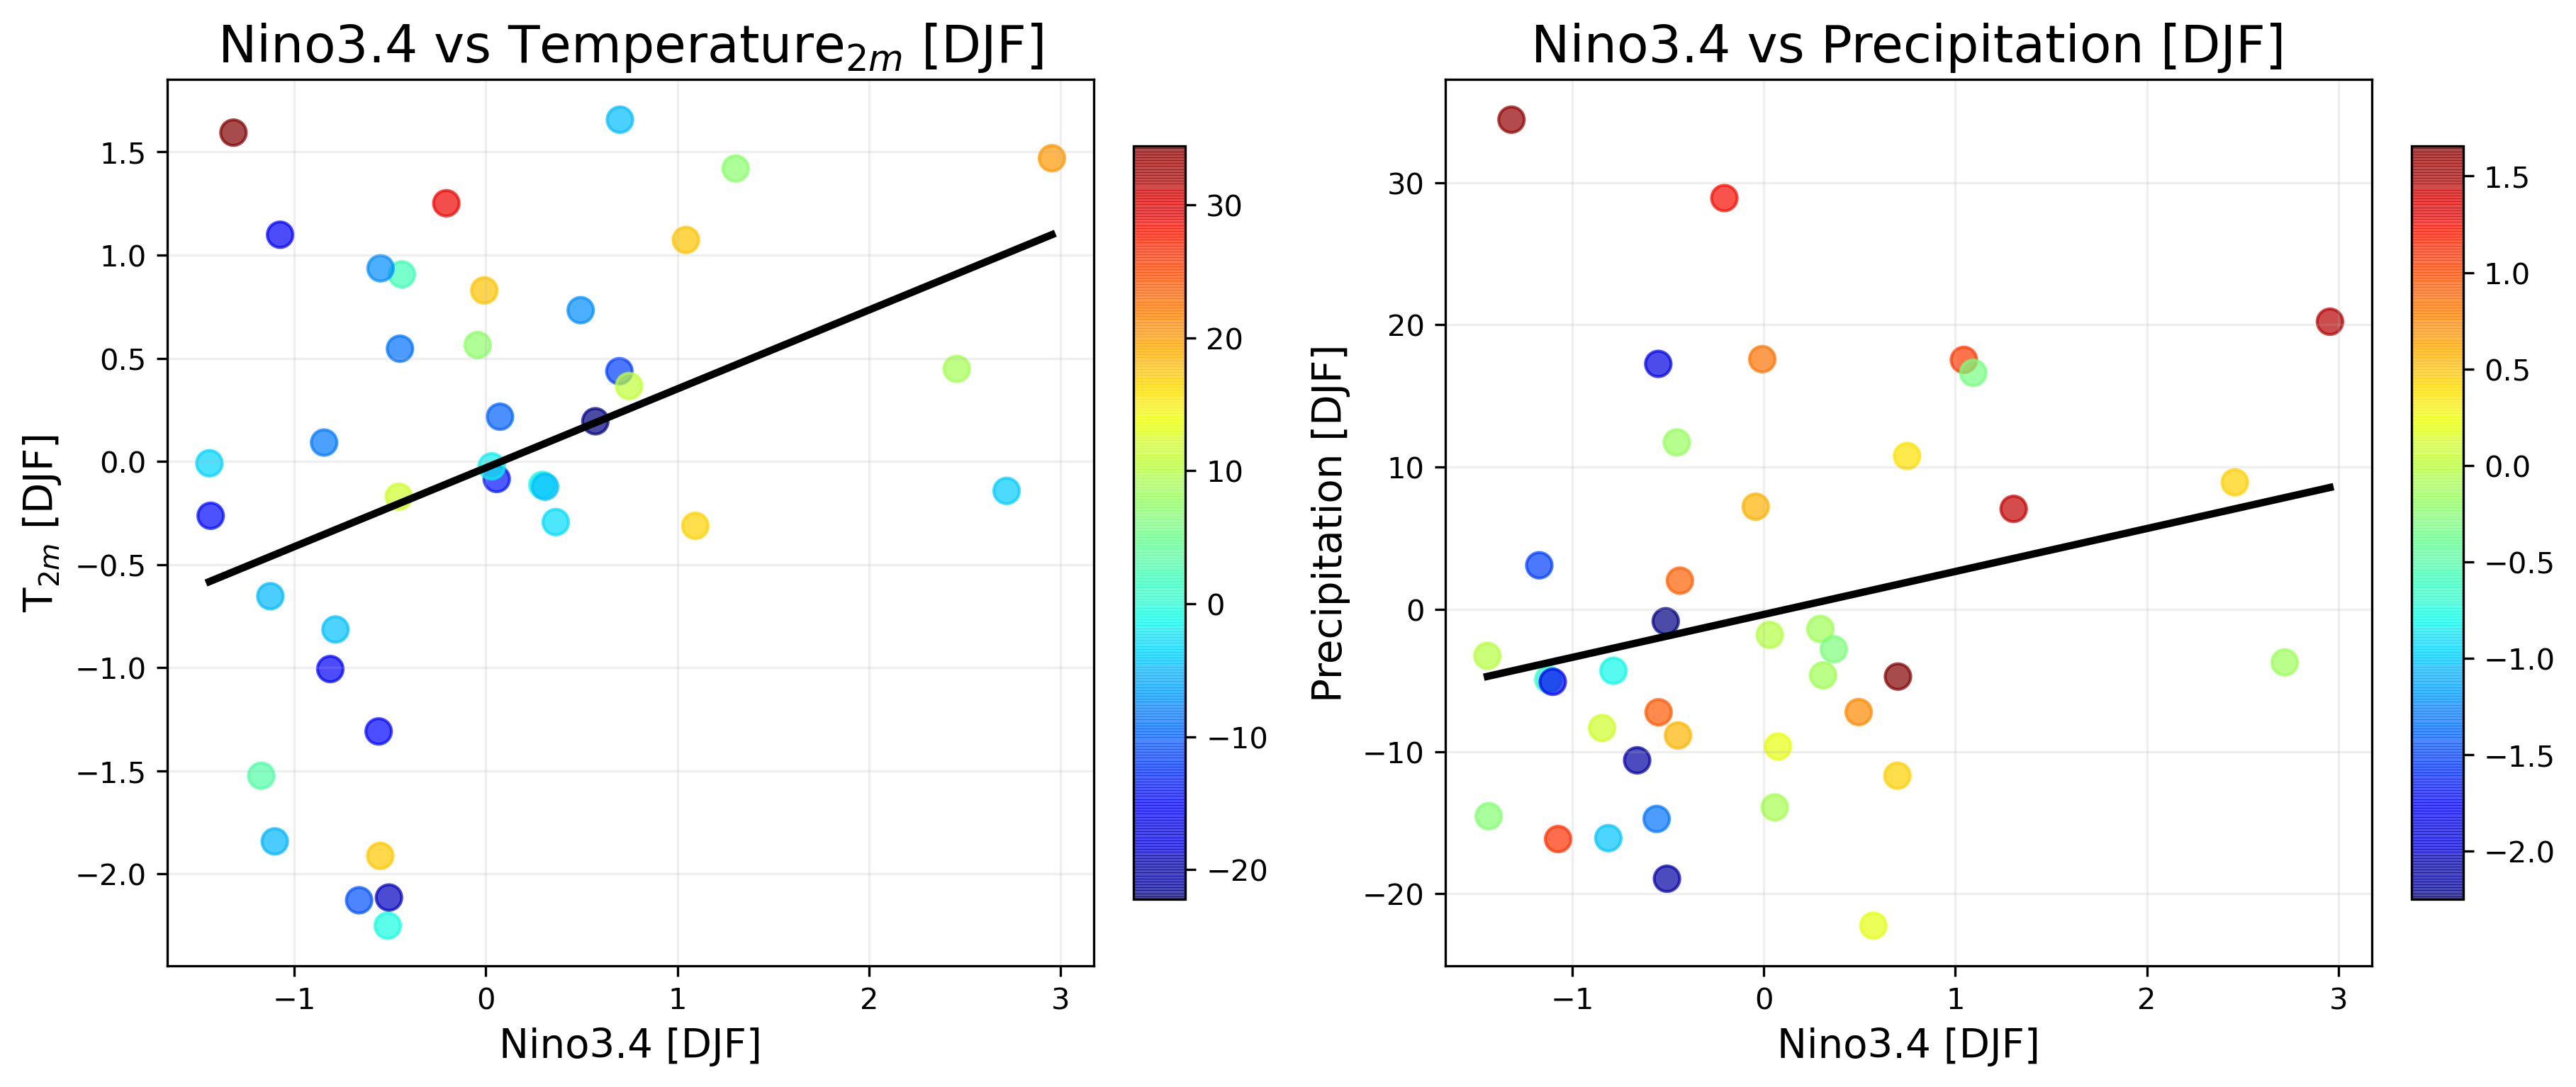

In [43]:
fig, axes = plt.subplots(1,2,figsize=(12,5),constrained_layout=True)


#### Plot Scatter plots between Nino3.4 & Mean temperature and precipitation
scat3 = axes[0].scatter(var1,var2,s=75,alpha=0.7,c=var3,cmap='jet')
scat4 = axes[1].scatter(var1,var3,s=75,alpha=0.7,c=var2,cmap='jet')

#### Plot Regression lines between Nino3.4 & Mean temperature and precipitation
xp, yp = calc_lin_regline(var1,var2)
axes[0].plot(xp,yp.T,color='k',linewidth=2.5)

xp, yp = calc_lin_regline(var1,var3)
axes[1].plot(xp,yp.T,color='k',linewidth=2.5)


#### Detail plot properties
cbar2 = fig.colorbar(scat3, location = 'right', ax = axes[0], 
                    shrink = 0.85, aspect = 35, pad = 0.02 )
cbar3 = fig.colorbar(scat4, location = 'right', ax = axes[1], 
                    shrink = 0.85, aspect = 35, pad = 0.02 )
for ind_plot in range(2): 
    axes[ind_plot].grid(alpha=0.2)
    axes[ind_plot].set_xlabel("Nino3.4 [DJF]",fontsize=13.5)
    
axes[0].set_ylabel("T$_{2m}$ [DJF]",fontsize=13.5)    
axes[1].set_ylabel("Precipitation [DJF]",fontsize=13.5)    

axes[0].set_title("Nino3.4 vs Temperature$_{2m}$ [DJF]",fontsize=17.5)
axes[1].set_title("Nino3.4 vs Precipitation [DJF]",fontsize=17.5)


#### <Save Time Series Figure to RESULT directory
dir_name   =  "./RESULT/"
file_name  =  "Scat_mean_Nino34_t2m_prcp.pdf"
path_name  =  dir_name+file_name
plt.savefig(path_name)